# Autoencoders

In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from fastprogress import progress_bar,master_bar
from miniai.datasets import *
from miniai.training import *
from miniai.conv import *

/Users/bytedance/venv/lib/python3.13/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

## Data

In [5]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [6]:
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [16]:
bs = 256
tds = dsd.with_transform(transformi)

torch.Size([1, 28, 28])

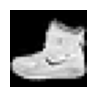

In [20]:
ds = tds['train']
img = ds[0]['image']
show_image(img, figsize=(1,1));
ds[0]['image'].shape

In [24]:
cf = collate_dict(ds)

In [61]:
def collate_(b): return to_device(cf(b))
def data_loaders(dsd, bs, **kwargs): return {k:DataLoader(v, bs, num_workers=8, **kwargs) for k,v in dsd.items()}

In [35]:
dls = data_loaders(tds, bs, collate_fn=collate_)

In [52]:
dt = dls['train']
dv = dls['test']

xb,yb = next(iter(dt))
xb.shape, yb.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

In [53]:
labels = ds.features[y].names

In [54]:
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [55]:
lbl_getter = itemgetter(*yb[:16])
titles = lbl_getter(labels)

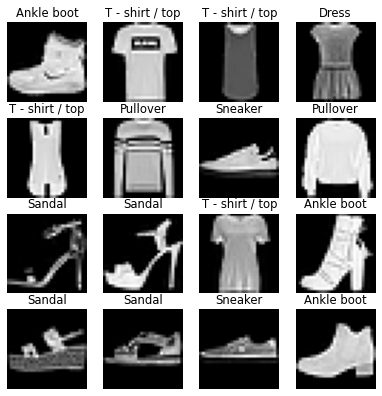

In [56]:
mpl.rcParams['figure.dpi'] = 70
show_images(xb[:16], imsize=1.7, titles=titles)

## Warmup - classify

In [57]:
from torch import optim

bs = 256
lr = 0.4

In [58]:
cnn = nn.Sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    conv(16,10, act=False),
    nn.Flatten()).to(def_device)

In [63]:
opt = optim.SGD(cnn.parameters(), lr=lr)
loss,acc = fit(10, cnn, F.cross_entropy, opt, dt, dv)

0 0.3662179293513298 0.8714
1 0.37013720161914826 0.8701
2 0.3658371430277824 0.8713
3 0.3572443905711174 0.8764
4 0.35963832893371583 0.8733
5 0.3594475692987442 0.8743
6 0.35536903364658357 0.8763
7 0.3595417562484741 0.8739
8 0.3678852640390396 0.8701
9 0.35873752291202543 0.8738


In [64]:
dsd['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

## Autoencoder

In [65]:
def deconv(ni, nf, ks=3, act=True):
    layers = [nn.UpsamplingNearest2d(scale_factor=2),
              nn.Conv2d(ni, nf, stride=1, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [66]:
def eval(model, loss_func, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss,count = 0.,0
        for xb,_ in valid_dl:
            pred = model(xb)
            n = len(xb)
            count += n
            tot_loss += loss_func(pred,xb).item()*n
    print(epoch, f'{tot_loss/count:.3f}')

In [67]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,_ in train_dl:
            loss = loss_func(model(xb), xb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        eval(model, loss_func, valid_dl, epoch)

In [68]:
ae = nn.Sequential(   #28x28
    nn.ZeroPad2d(2),  #32x32
    conv(1,2),        #16x16
    conv(2,4),        #8x8
#     conv(4,8),        #4x4
#     deconv(8,4),      #8x8
    deconv(4,2),      #16x16
    deconv(2,1, act=False), #32x32
    nn.ZeroPad2d(-2), #28x28
    nn.Sigmoid()
).to(def_device)

In [69]:
eval(ae, F.mse_loss, dv)

0 0.188


In [70]:
opt = optim.SGD(ae.parameters(), lr=0.01)
fit(5, ae, F.mse_loss, opt, dt, dv)

0 0.159
1 0.144
2 0.136
3 0.131
4 0.128


In [71]:
opt = optim.SGD(ae.parameters(), lr=0.1)
fit(5, ae, F.mse_loss, opt, dt, dv)

0 0.046
1 0.034
2 0.030
3 0.026
4 0.022


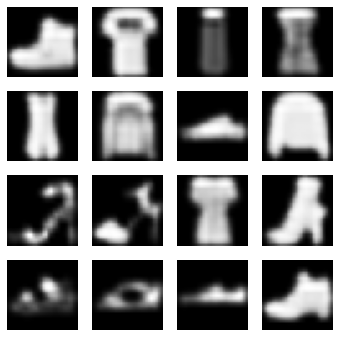

In [72]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

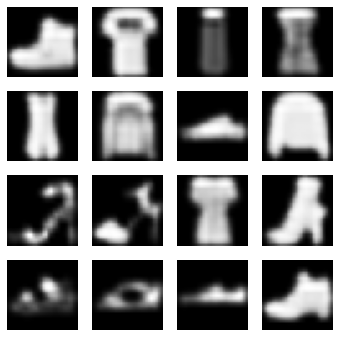

In [73]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

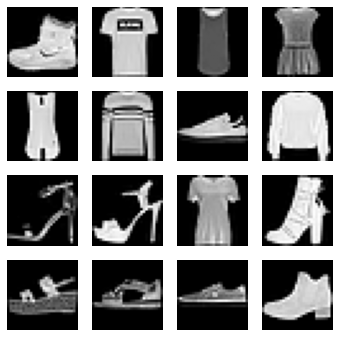

In [74]:
show_images(xb[:16].data.cpu(), imsize=1.5)